# Awesome NTDS project 

bla bla bla

## 1. Dependencies

*Matplotlib* do not cope well with large scale 3D data visualization. This can be overcomed by the use of `mayavi` package (*build on top of OpenGL pipeline*). It can be installed on your machine with the following commands (based on [#473](https://github.com/enthought/mayavi/issues/473#issuecomment-352033311)):

```
$ conda install -c clinicalgraphics vtk=7.1.1
$ pip install git+https://github.com/enthought/pyface.git
$ pip install git+https://github.com/enthought/traitsui.git
$ pip install git+https://github.com/enthought/mayavi.git
```

In order to use it in a `jupyter` notebook, some extension need to be installed. The command listed below will do it:

```
$ jupyter nbextension install --py mayavi --user
```


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import platform
from utils import *
from mesh import *
from deformation import *
import numpy as np
import os
from scipy import sparse
# Mayavi stuff, can be a bit tricky on OSX
# OSX: x3d interactive backend but still buggy
# Linux: png Offscreen rendering since x3d backend schrinks when plotted
backend = 'x3d' if platform.system() == 'Darwin' else 'png'
from mayavi import mlab
mlab.init_notebook(backend, local=False)

# Base folder where data are located, user-specific since location
data_folder = '../data'

Notebook initialized with png backend.


## 2. Introduction

** AWESOMSE STUFF **

## 3. Data Analysis

Can we recover some morphological properties such as facial expressions, or ethnies within the dataset ?

## 4. Graph-based deformation learning

In this section, the deformation between different facial expressions will be investigated under two formulations:

- Deformation field
- Constrainted reconstruction

### 4.1 Deformation field

Every meshes in the dataset are densely registered, all the vertices have the same semantics. Therefore the targeted surface $\boldsymbol{x}^t$ can be defined with respect of the source $\boldsymbol{x}^s$ and a deformation field $\boldsymbol{d}$.

$$ \boldsymbol{x}^t = \boldsymbol{x}^s + \boldsymbol{d} $$

The goal is to estimate the deformation field only using a sparse subset of $K$ target's vertices. The deformation learning can be formulated using graph-based tool as follow:

$$ \boldsymbol{d}^*_i = argmin \quad \left|\left| M \left(\boldsymbol{x}_i^s + \boldsymbol{d}_i \right) - \boldsymbol{x}_i^t \right|\right|_2^2 + \alpha \boldsymbol{d}_i^{\top}\boldsymbol{L} \boldsymbol{d}_i $$

where:

- $\boldsymbol{x}_i^s \in \mathbb{R}^{N \times 1}, i \in \{x,y,z \}$ the source's component
- $\boldsymbol{x}_i^s \in \mathbb{R}^{K \times 1}, i \in \{x,y,z \}$ the target's component
- $\boldsymbol{M} \in \mathbb{R}^{K \times M}$ a selection operator
- $\boldsymbol{L} \in \mathbb{R}^{N \times N}$ the laplacian operator
- $\boldsymbol{d}_i \in \mathbb{R}^{N \times 1}, i \in \{x,y,z\}$ the deformation field's component
- $\alpha$, the regularization factor balancing the two terms

#### 4.1.1. Anchor selection

In order to have constraints over all surface's points, the anchors are selected using a downsampled version of the original mesh. The sources is decimated by a factor of $20$ using algorithm based on [Surface Simplification Using Quadric Error Metrics](https://www.ri.cmu.edu/pub_files/pub2/garland_michael_1997_1/garland_michael_1997_1.pdf).
The selection operator is build from the anchor's indexes $a_i \in C$ computed previously. The operator $\boldsymbol{M}$ is defined as:

$$ \boldsymbol{M}_{ij} = \begin{cases} 1 & \mbox{if } j \in C \\ 0 & otherwise \end{cases} $$

In [2]:
# Load source + target meshes + anchors
tri = utils.load_triangulation(os.path.join(data_folder, 'FWTri/fw_triangulation.tri'))
meshes = utils.load_meshes(os.path.join(data_folder, 'FWMesh/115_shape.bs'), [0, 22])
anchors = utils.load_anchor_point(os.path.join(data_folder, 'anchors.cfg'))

In [3]:
# Create mesh instances for source and target surface
mesh_xs = Mesh(meshes[0], tri)
mesh_xt = Mesh(meshes[1], tri)
N = meshes[0].shape[0]
# Dump meshes into .obj file
mesh_xs.save('source.obj')
mesh_xt.save('target.obj')
# Define ground-truth
d_true = mesh_xt.vertex - mesh_xs.vertex
d_norm = np.linalg.norm(d_true, axis=1)


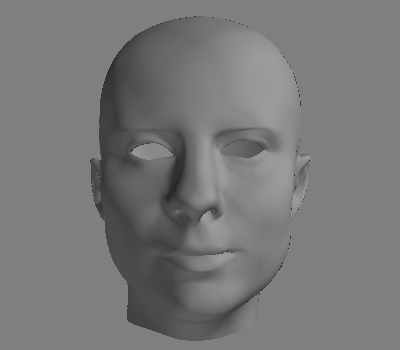

In [4]:
# Source surface
mlab.clf()
color = (0.5, 0.5, 0.5)
trimesh_xs = mlab.triangular_mesh(mesh_xs.vertex[:,0], mesh_xs.vertex[:,1], mesh_xs.vertex[:,2], mesh_xs.tri, color=color)
mlab.view(0,0)
trimesh_xs

Figure above shows an example of $\boldsymbol{x}^s$ used as source for the deformation estimation


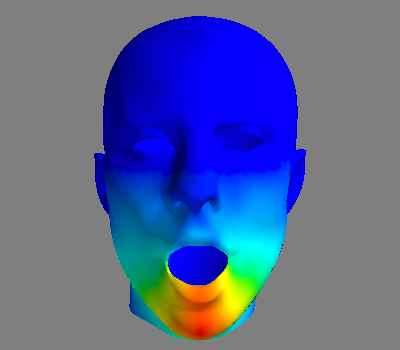

In [5]:
# Target surface, with displacment color coded (Red = large).  
mlab.clf()
trimesh_xt = mlab.triangular_mesh(mesh_xt.vertex[:,0], mesh_xt.vertex[:,1], mesh_xs.vertex[:,2], mesh_xt.tri, scalars=d_norm)
mlab.view(0, 0)
trimesh_xt

Figure above shows an example of a targetted expressions, $\boldsymbol{x}^t$, that need to be recovered. The colors represents the distance from the source, $\boldsymbol{x}^s$, which is the deformation $\boldsymbol{d}$ that needs to be estimated.

In [6]:
# 1) create selection mask
K = len(anchors)
ridx = [k for k in range(K)]
cidx = anchors
data = [1.0] * K
M = sparse.coo_matrix((data, (ridx, cidx)), shape=(K, N), dtype=np.float32)
# 2) Comptue laplacian
_,_, Lap = mesh_xs.compute_laplacian('cotan')
# 3) Compute target
Xs = mesh_xs.vertex
Xt = M.dot(mesh_xt.vertex)

In [7]:
# 4) Estimate deformation field without regularization
estm_xt, d = deform_regularized_anchor(Xs, Xt, M, Lap, 0.05)
# Error
err = np.linalg.norm(estm_xt - mesh_xt.vertex, axis=1)
e_def = np.mean(err)
print('Mean error of %f, for %d anchors' % (e_def, K))
m = Mesh(estm_xt, tri)
m.save('deformation_field.obj')

Mean error of 0.002153, for 587 anchors



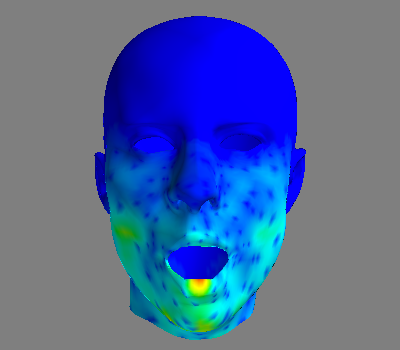

In [8]:
mlab.clf()
trimesh_xt_estm = mlab.triangular_mesh(estm_xt[:,0], estm_xt[:,1], estm_xt[:,2], mesh_xt.tri, scalars=err)
mlab.view(0, 0)
trimesh_xt_estm

Figure above shows the estimated target surface. The color represents the point-to-point error between the two surfaces. The sparse blue dots on the surface can be explained by the fact that they are the vertices correspoinding to the anchor points, therefore the error at those locations is small compare to the rest of the surface. Regardings the other parts such as the top of the skull or the ears, the erros is minimum since the is not deformation in those area.

However the deformation field in the mouth region is not approximated correctly (*i.e. around the lips*) and lead to unrealistic solutions.

### 4.2 Constrainted Reconstruction

The second approach try to estimate directly the target surface $\boldsymbol{x}^t$ from a set of constraints. There are two types of constraints, the first one are related to the surface curvature and the second one are related to absolute position in space.

When applying the Laplacian operator on vertices, $(\boldsymbol{Lx})_{i} =  \frac{1}{d_i} \sum_{j \in N(i)} \left(\boldsymbol{x}_i - \boldsymbol{x}_j \right)$, it provides an estimation of the local curvature for each vertices. Therefore we can constraint the target's local curvature to be close to the source one $\boldsymbol{Lx}^t \approx \boldsymbol{Lx}^s$. Solving this problem will not gives a unique solution since the Laplacian operator is not full rank (*i.e. there is at least one eigenvalue equal to zero*). Therefore more constraints need to be added. The Laplacian is augmented with positional contraints. Finally we have:

$$ \boldsymbol{\delta}^s = \boldsymbol{Lx}^s $$

$$ \left[ \begin{array}{c} \boldsymbol{L} \\ \lambda \boldsymbol{A} \end{array} \right]\boldsymbol{x}^t = \left[ \begin{array}{c} \boldsymbol{\delta}^s \\ \lambda \boldsymbol{C}^t \end{array} \right] $$

where

$$ \boldsymbol{A}_{ij} = \begin{cases} 1 & \mbox{if } j \in C \\ 0 & otherwise \end{cases} $$
$$ \boldsymbol{C}^t_{(0... k)} = \boldsymbol{x}^t_k,  k \in C $$

[ref](https://people.eecs.berkeley.edu/~jrs/meshpapers/Sorkine.pdf)

In [9]:
# Reuse the same anchors for fare comparison, comparison with subset will be conducted below
anchorsIdx = anchors
anchors_pts = mesh_xt.vertex[anchorsIdx, :]
# Deform
estm_xt = deform_mesh(mesh_xs, anchors_pts, anchorsIdx, 1.0)
# Error
err = np.linalg.norm(estm_xt - mesh_xt.vertex, axis=1)
e = np.mean(err)
print('Mean error: %f, for %d anchors' % (e, len(anchorsIdx)))

Mean error: 0.001216, for 587 anchors



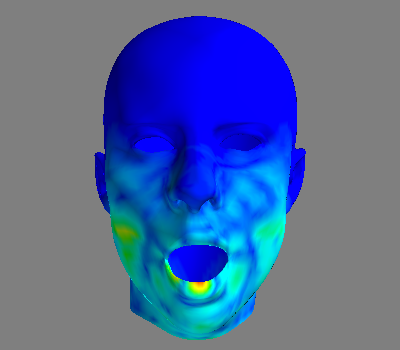

In [10]:
mlab.clf()
trimesh_xt_estm = mlab.triangular_mesh(estm_xt[:,0], estm_xt[:,1], estm_xt[:,2], mesh_xt.tri, scalars=err)
mlab.view(0, 0)
trimesh_xt_estm

Figure above shows the result with positional and curvature constraints. Using the same set of anchors the average per-vertex error is smaller and the deformation is more realistic than previously shown.

In [11]:
# Analyse error with respect to the number of anchor points selected. What happen if we take only a subset of
# the original anchor set ?
err_step = []
estm_step = []
n_step = 11
for k in range(1, n_step):
    idx = np.random.permutation(anchors)
    n_idx = k * int(len(anchors) / n_step)
    anchorsIdx = idx[0:n_idx]
    anchors_pts = mesh_xt.vertex[anchorsIdx, :]
    # Deform
    estm_xt = deform_mesh(mesh_xs, anchors_pts, anchorsIdx, 1.0)
    estm_step.append(estm_xt)
    # Error
    err = np.linalg.norm(estm_xt - mesh_xt.vertex, axis=1)
    e = np.mean(err)
    print('Mean error: %f, for %d anchors' % (e, len(anchorsIdx)))
    err_step.append(e)

Mean error: 0.005685, for 53 anchors
Mean error: 0.004574, for 106 anchors
Mean error: 0.003603, for 159 anchors
Mean error: 0.002741, for 212 anchors
Mean error: 0.002139, for 265 anchors
Mean error: 0.001818, for 318 anchors
Mean error: 0.001680, for 371 anchors
Mean error: 0.001569, for 424 anchors
Mean error: 0.001419, for 477 anchors
Mean error: 0.001276, for 530 anchors


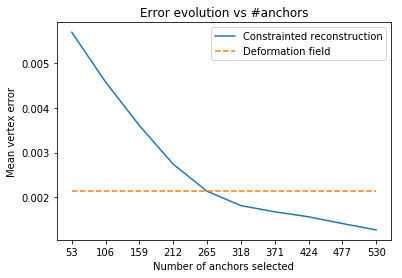

In [12]:
# Error comparisons
plt.plot(err_step)
plt.title('Error evolution vs #anchors')
plt.ylabel('Mean vertex error')
plt.xlabel('Number of anchors selected')
x = [k * int(len(anchors) / n_step) for k in range(1, n_step)]
xi = [k for k in range(0, n_step - 1)]
plt.xticks(xi, x)
# Deformation field
plt.plot([0, xi[-1]],[e_def, e_def], '--')
# Legend
plt.legend(['Constrainted reconstruction', 'Deformation field'])
plt.show()

This plot shows the evolution of the average per-vertex error when the number of anchors is augemented. The deformation field estimated earlier is used as baseline for comparison (*i.e. estimated with all anchors !*).

It shows that the number of anchors can be reduced to achieve similar performance in term of error while keeping a realistic solution. The solution recovered with 318 anchor points is displayed in the next figure.



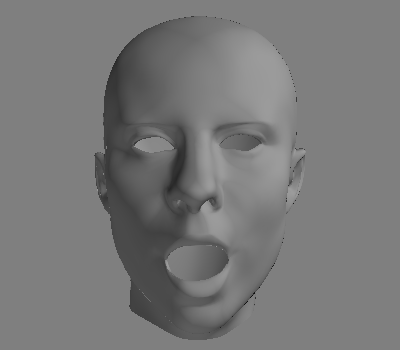

In [13]:
mlab.clf()
trimesh_xt_estm_5 = mlab.triangular_mesh(estm_step[5][:,0], estm_step[5][:,1], estm_step[5][:,2], mesh_xt.tri, color=(0.5, 0.5, 0.5))
mlab.view(0, 0)
trimesh_xt_estm_5

### 4.3 Laplacian Operator

During our experiments, it has be seen that response to the Laplacian change depending on the tessalation of the surface.

In [14]:
# Load mesh
sph = Mesh()
sph.load(os.path.join(data_folder, 'sphere_unregular.obj'))
# Compute two variant of laplacian
_,_, lap_comb = sph.compute_laplacian('combinatorial')
_,_, lap_cotan = sph.compute_laplacian('cotan')
# Get eigen vectors
import scipy.sparse.linalg

_, eigv_comb = sparse.linalg.eigsh(lap_comb, which='SM')
_, eigv_cotan = sparse.linalg.eigsh(lap_cotan, which='SM')


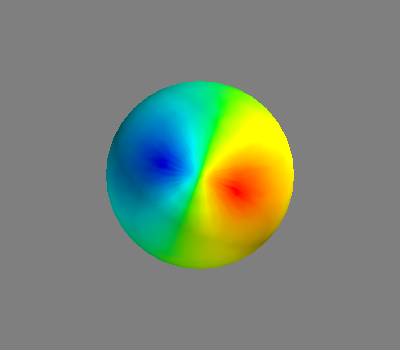

In [16]:
idx = 2
mlab.clf()
trimesh_comb = mlab.triangular_mesh(sph.vertex[:,0], sph.vertex[:,1], sph.vertex[:,2], sph.tri, scalars=eigv_comb[:,idx])
mlab.view(90, 90, 7.0)
trimesh_comb


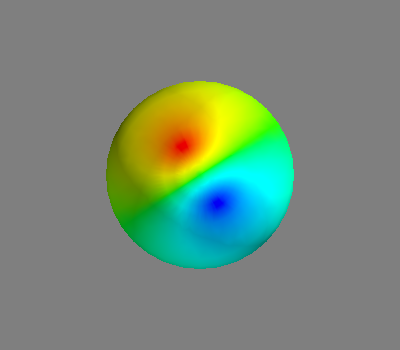

In [17]:
mlab.clf()
trimesh_cotan = mlab.triangular_mesh(sph.vertex[:,0], sph.vertex[:,1], sph.vertex[:,2], sph.tri, scalars=eigv_cotan[:,idx])
mlab.view(90, 90, 7.0)
trimesh_cotan

## 5. Conclusions

bla bla